<a href="https://colab.research.google.com/github/ranjanguddu/Machine-Learning/blob/master/EVA4/Assignment-09/QuizDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from datetime import datetime
import pytz
print(datetime.now(pytz.timezone('Asia/Kolkata')))

2020-03-21 18:45:45.592619+05:30


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import os
os.chdir('/content/gdrive/My Drive/EVA4_Assignment')

In [5]:
!ls -l


total 31
drwx------ 2 root root 4096 Mar 14 11:22  Assignmnet-07
drwx------ 3 root root 4096 Mar 21 12:10  data
-rw------- 1 root root 1449 Mar 21 11:34 'Data_Loader (1).py'
-rw------- 1 root root 1256 Mar 15 03:58  Data_Loader.py
-rw------- 1 root root 1449 Mar 21 11:34  Data_Load.py
-rw------- 1 root root  713 Mar 15 04:02 'Data_Transform (1).py'
-rw------- 1 root root  718 Mar 21 12:06  Data_Transform.py
-rw------- 1 root root 2562 Mar 14 13:37  Edited_ResNet.py
drwx------ 2 root root 4096 Mar 21 11:31  models
drwx------ 2 root root 4096 Mar 21 12:08  __pycache__
-rw------- 1 root root 2218 Mar 21 11:34 'Train_Model (1).py'
-rw------- 1 root root 2401 Mar 14 13:14  Train_Model.py


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
# Import pytorch utilities from albumentations
import albumentations as A

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from Edited_ResNet import ResNet18
%matplotlib inline

In [0]:
from albumentations import (Compose, HorizontalFlip, Cutout, Rotate)
from PIL import Image
def strong_aug(p=0.5):
  return Compose([HorizontalFlip(),
                  Rotate(limit=(-30, 30)),
                  Cutout(num_holes=4, max_h_size=4, max_w_size=4)
                  ], p=p)
  
def augment(aug, image):
  return aug(image=image)['image']

class MyTransform(object):
  def __call__(self, img):
    aug = strong_aug(p=1)
    return Image.fromarray(augment(aug,  np.array(img)))

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       MyTransform(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [9]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transforms)
                                          

Files already downloaded and verified
Files already downloaded and verified


In [10]:
SEED = 101

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=False, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
small_loader = torch.utils.data.DataLoader(trainset, batch_size= 1)
# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 frog truck truck  deer   car   car  bird horse


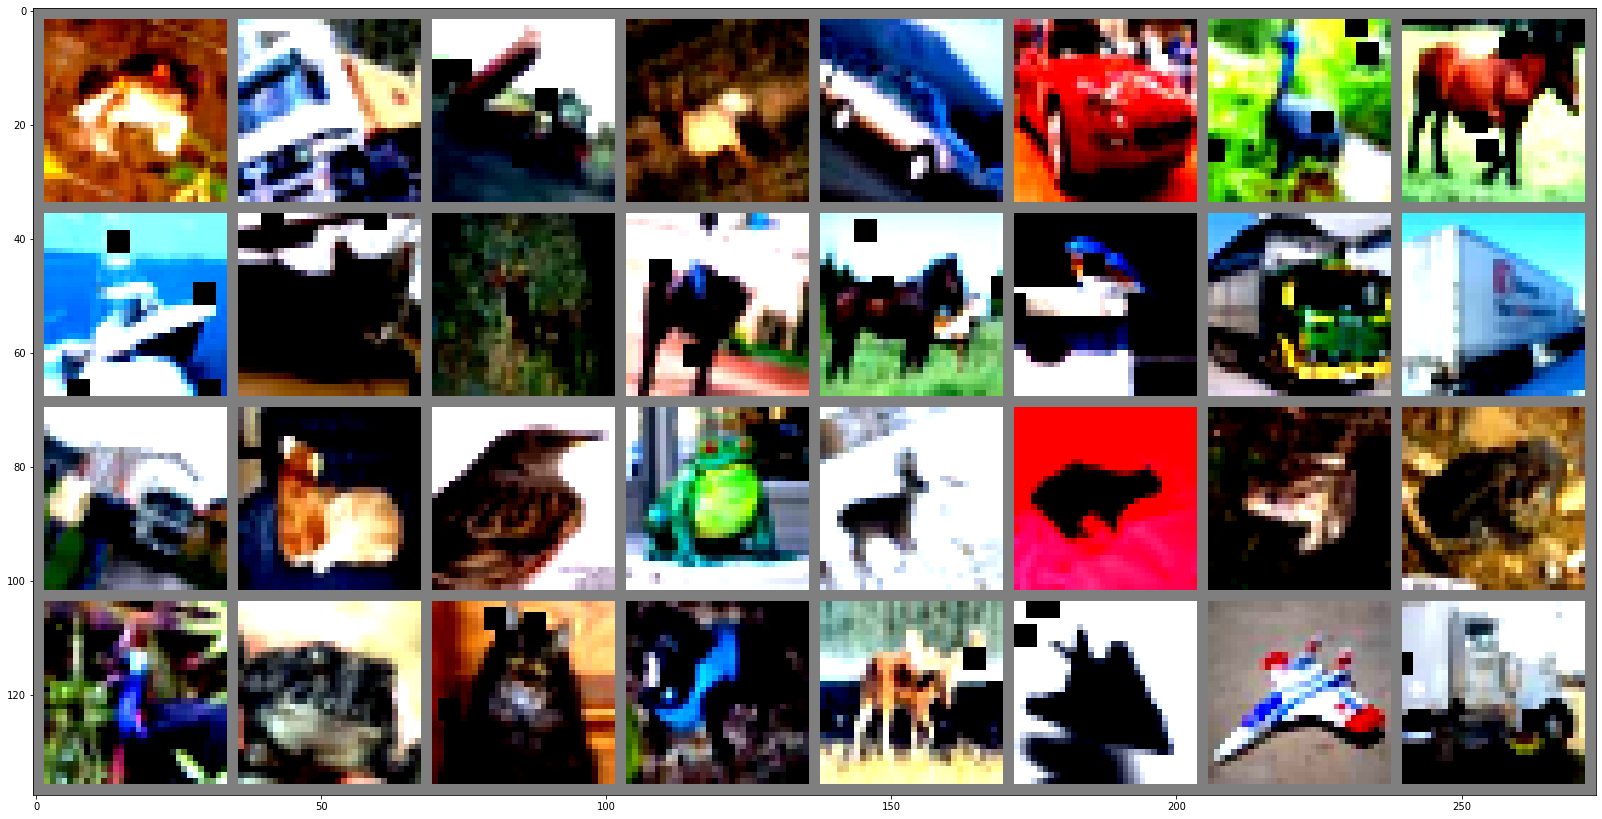

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# functions to show an image


def imshow(img):
    plt.figure(figsize=(28,15))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(8)))

In [0]:
z

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_val = 0.1


        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(16), nn.Dropout(dropout_val), # 32x32x16
                                   nn.Conv2d(16,32,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(32), nn.Dropout(dropout_val),# 32x32x32
                                   #nn.Conv2d(20,16,1, bias=True, padding='0),nn.ReLU(), #24x24x20
                                   nn.MaxPool2d(2, 2), #16x16x32
            
                                   )
        self.conv2 =  nn.Sequential(nn.Conv2d(32,64,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(64), nn.Dropout(dropout_val), #16x16x64
                                   nn.Conv2d(64,64,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(64), nn.Dropout(dropout_val),   #16x16x64
                                   nn.Conv2d(64,128,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(128), nn.Dropout(dropout_val),   #16x16x128
                                   nn.MaxPool2d(2, 2)) #8x8x128
                                    
        self.conv3 =  nn.Sequential(nn.Conv2d(128,256,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(256), nn.Dropout(dropout_val), #8x8x256
                                   nn.Conv2d(256,512,3, bias=True, padding=1),nn.ReLU(), nn.BatchNorm2d(512), nn.Dropout(dropout_val),   #8x8x512
                                   nn.Conv2d(512,10,3, bias=True),nn.ReLU(), nn.BatchNorm2d(10), nn.Dropout(dropout_val) #6x6x10
                                   )  
        
          
        

        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6))

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
           
        ) 


        #self.dropout = nn.Dropout(dropout_value)

                                    

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)        
        #x = self.conv4(x)

        x = x.view(-1, 10)
        return x

        
        
        

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
netobj = Net()

model = netobj.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0009)

In [0]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import time

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  t0=time.time()
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples and push the data and target to GPU
    data, target = data.to(device), target.to(device)

    # Set the gradient ZERO because it acculumates from previous conversion
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)

    # Backpropagation
    loss.backward()
    optimizer.step()

    train_loss += loss

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    Training_Loss= train_loss/(batch_idx+1)
    
    pbar.set_description(desc= f'Loss={Training_Loss} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} ')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    #test_loss /= len(test_loader.dataset)
    Test_LOSS = test_loss/(batch_idx+1)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        Test_LOSS, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:


EPOCHS = 10


for epoch in range(EPOCHS):
    t0=time.time()
    print("\nEPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)
    t1= time.time()
    print("Time taken in epoch {} is {:.2f}\n".format(epoch+1, (t1-t0)))


  0%|          | 0/1563 [00:00<?, ?it/s]


EPOCH: 1


Loss=1.5518512725830078 Batch_id=1562 Accuracy=45.14 : 100%|██████████| 1563/1563 [00:38<00:00, 40.88it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.2194, Accuracy: 5811/10000 (58.11%)

Time taken in epoch 1 is 40.96


EPOCH: 2


Loss=1.224759817123413 Batch_id=1562 Accuracy=57.89 : 100%|██████████| 1563/1563 [00:37<00:00, 41.16it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.9860, Accuracy: 6677/10000 (66.77%)

Time taken in epoch 2 is 40.68


EPOCH: 3


Loss=1.0666154623031616 Batch_id=1562 Accuracy=63.45 : 100%|██████████| 1563/1563 [00:37<00:00, 42.07it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.8389, Accuracy: 7124/10000 (71.24%)

Time taken in epoch 3 is 39.99


EPOCH: 4


Loss=0.9640033841133118 Batch_id=1562 Accuracy=67.21 : 100%|██████████| 1563/1563 [00:37<00:00, 41.65it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.7114, Accuracy: 7650/10000 (76.50%)

Time taken in epoch 4 is 40.26


EPOCH: 5


Loss=0.8994131088256836 Batch_id=1562 Accuracy=69.39 : 100%|██████████| 1563/1563 [00:37<00:00, 41.75it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6786, Accuracy: 7761/10000 (77.61%)

Time taken in epoch 5 is 40.10


EPOCH: 6


Loss=0.8551120162010193 Batch_id=1562 Accuracy=71.18 : 100%|██████████| 1563/1563 [00:38<00:00, 41.06it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6259, Accuracy: 7930/10000 (79.30%)

Time taken in epoch 6 is 40.81


EPOCH: 7


Loss=0.8327704668045044 Batch_id=1562 Accuracy=71.62 : 100%|██████████| 1563/1563 [00:37<00:00, 41.55it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6220, Accuracy: 7931/10000 (79.31%)

Time taken in epoch 7 is 40.38


EPOCH: 8


Loss=0.8037927746772766 Batch_id=1562 Accuracy=72.82 : 100%|██████████| 1563/1563 [00:38<00:00, 40.85it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6192, Accuracy: 7976/10000 (79.76%)

Time taken in epoch 8 is 41.07


EPOCH: 9


Loss=0.7890254259109497 Batch_id=1562 Accuracy=73.25 : 100%|██████████| 1563/1563 [00:38<00:00, 40.88it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5950, Accuracy: 8046/10000 (80.46%)

Time taken in epoch 9 is 41.03


EPOCH: 10


Loss=0.7749728560447693 Batch_id=1562 Accuracy=73.80 : 100%|██████████| 1563/1563 [00:37<00:00, 41.20it/s]



Test set: Average loss: 0.5823, Accuracy: 8077/10000 (80.77%)

Time taken in epoch 10 is 40.63

